This guide shows how to train and infer [Clay Foundation Model](https://clay-foundation.github.io/model/index.html) for segmentation task ([Chesapeake Land Cover
](https://lila.science/datasets/chesapeakelandcover)) using our API.

<a target="_blank" href="https://colab.research.google.com/github/bluesightai/docs/blob/main/guides/train-a-land-segmentation.ipynb">
  <img noZoom src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
API_URL = "https://api.bluesight.ai"

GSD = 1.0
CHIP_SIZE = 224
COLLECTION = "naip"
BANDS = ["red", "green", "blue", "nir"]

DATA_DIR = "./data"
N_TRAIN_SAMPLES = 1000
N_TEST_SAMPLES = 100

RANDOM_SEED = 42
HEADERS = {"Content-Type": "application/json"}

In [ ]:
!pip install awscli numpy scikit-learn gdown requests-toolbelt h5py

## Loading Data

In [ ]:
!aws s3 cp s3://us-west-2.opendata.source.coop/agentmorris/lila-wildlife/lcmcvpr2019/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-train_tiles/ data/train/ --recursive --no-sign-request --region us-west-2 --exclude "*" --include "*_lc.tif" --include "*_naip-new.tif"
!aws s3 cp s3://us-west-2.opendata.source.coop/agentmorris/lila-wildlife/lcmcvpr2019/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-val_tiles/ data/val/ --recursive --no-sign-request --region us-west-2 --exclude "*" --include "*_lc.tif" --include "*_naip-new.tif"

## Preparing Data

https://github.com/Clay-foundation/model/blob/main/finetune/segment/preprocess_data.py

In [2]:
import os
import re
from pathlib import Path

import numpy as np
import rasterio as rio
from tqdm import tqdm

DATA_DIR = Path(DATA_DIR)
OUTPUT_DIR = DATA_DIR / "output"

In [3]:
def read_and_chip(file_path, chip_size, output_dir):
    """
    Reads a GeoTIFF file, creates chips of specified size, and saves them as
    numpy arrays.

    Args:
        file_path (str or Path): Path to the GeoTIFF file.
        chip_size (int): Size of the square chips.
        output_dir (str or Path): Directory to save the chips.
    """
    os.makedirs(output_dir, exist_ok=True)

    with rio.open(file_path) as src:
        data = src.read()

        n_chips_x = src.width // chip_size
        n_chips_y = src.height // chip_size

        chip_number = 0
        for i in range(n_chips_x):
            for j in range(n_chips_y):
                x1, y1 = i * chip_size, j * chip_size
                x2, y2 = x1 + chip_size, y1 + chip_size

                chip = data[:, y1:y2, x1:x2]
                chip_path = os.path.join(
                    output_dir,
                    f"{Path(file_path).stem}_chip_{chip_number}.npy",
                )
                np.save(chip_path, chip)
                chip_number += 1


def process_files(file_paths, output_dir, chip_size):
    """
    Processes a list of files, creating chips and saving them.

    Args:
        file_paths (list of Path): List of paths to the GeoTIFF files.
        output_dir (str or Path): Directory to save the chips.
        chip_size (int): Size of the square chips.
    """
    for file_path in tqdm(file_paths):
        read_and_chip(file_path, chip_size, output_dir)
        

train_image_paths = list((DATA_DIR / "train").glob("*_naip-new.tif"))
train_label_paths = list((DATA_DIR / "train").glob("*_lc.tif"))
val_image_paths = list((DATA_DIR / "val").glob("*_naip-new.tif"))
val_label_paths = list((DATA_DIR / "val").glob("*_lc.tif"))

process_files(train_image_paths, OUTPUT_DIR / "train/chips", CHIP_SIZE)
process_files(train_label_paths, OUTPUT_DIR / "train/labels", CHIP_SIZE)
process_files(val_image_paths, OUTPUT_DIR / "val/chips", CHIP_SIZE)
process_files(val_label_paths, OUTPUT_DIR / "val/labels", CHIP_SIZE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


In [4]:
train_chip_names = [chip_path.name for chip_path in list((OUTPUT_DIR / "train/chips").glob("*.npy"))]
train_label_names = [re.sub("_naip-new_", "_lc_", chip) for chip in train_chip_names]

val_chip_names = [chip_path.name for chip_path in list((OUTPUT_DIR / "val/chips").glob("*.npy"))]
val_label_names = [re.sub("_naip-new_", "_lc_", chip) for chip in val_chip_names]

In [5]:
from pathlib import Path

import h5py
import numpy as np
from tqdm import tqdm

num_bands = len(BANDS)

dt = np.dtype(
    [
        ("bands", f"S10", (num_bands,)),  # Adjust '10' if your band names are longer
        ("gsd", "float32"),
        ("pixels", "float32", (num_bands, CHIP_SIZE, CHIP_SIZE)),
        ("platform", "S20"),  # Adjust '20' if your platform names are longer
        ("point", "float32", (2,)),
        ("timestamp", "int64"),
        ("label", "int64", (CHIP_SIZE, CHIP_SIZE)),
    ]
)


label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 15: 6}
output_file = "land_segmentation_train_data.h5"
with h5py.File(output_file, "w") as f:

    dataset = f.create_dataset(
        "data", (N_TRAIN_SAMPLES,), dtype=dt, compression="gzip", compression_opts=1, chunks=(min(1, N_TRAIN_SAMPLES),)
    )

    for i, chip_name in enumerate(tqdm(train_chip_names[:N_TRAIN_SAMPLES])):
        
        label_name = re.sub("_naip-new_", "_lc_", chip_name)

        dataset[i] = (
            [band.encode("ascii", "ignore") for band in BANDS],
            GSD,
            np.load(OUTPUT_DIR / "train/chips" / chip_name).astype("float32"),
            COLLECTION.encode("ascii", "ignore"),
            [0, 0],
            0,
            np.vectorize(label_mapping.get)(np.load(OUTPUT_DIR / "train/labels" / label_name).squeeze()).astype("int64")
        )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.96it/s]


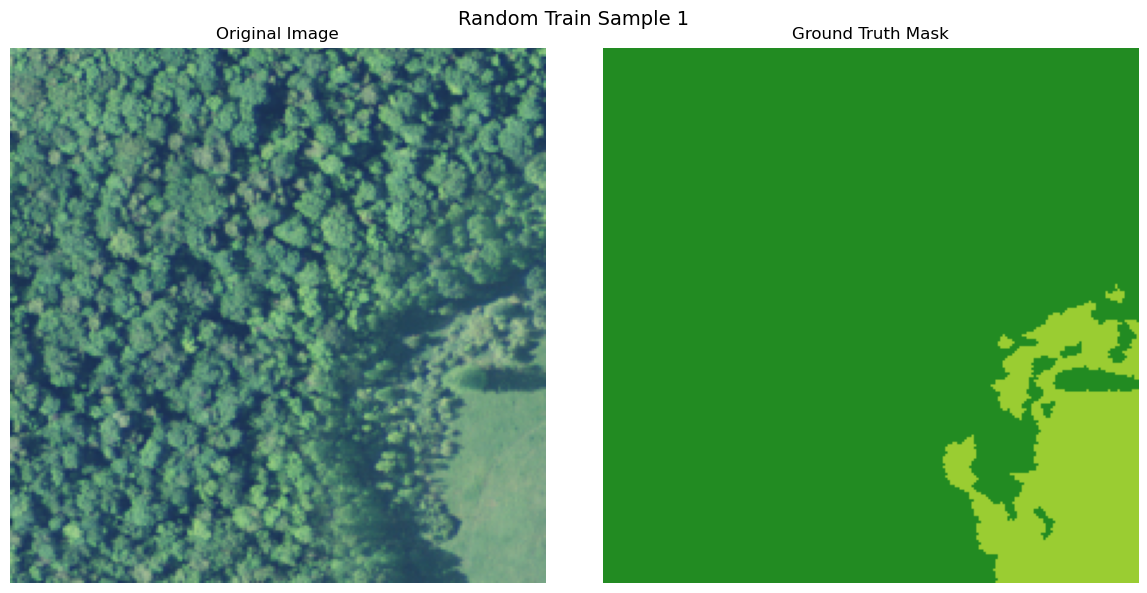

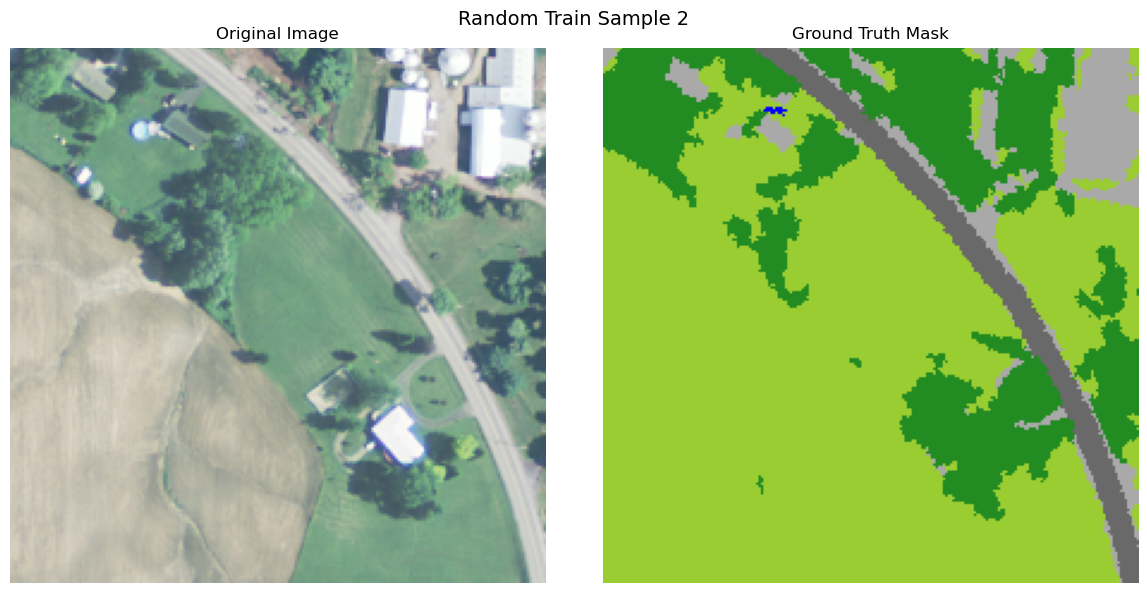

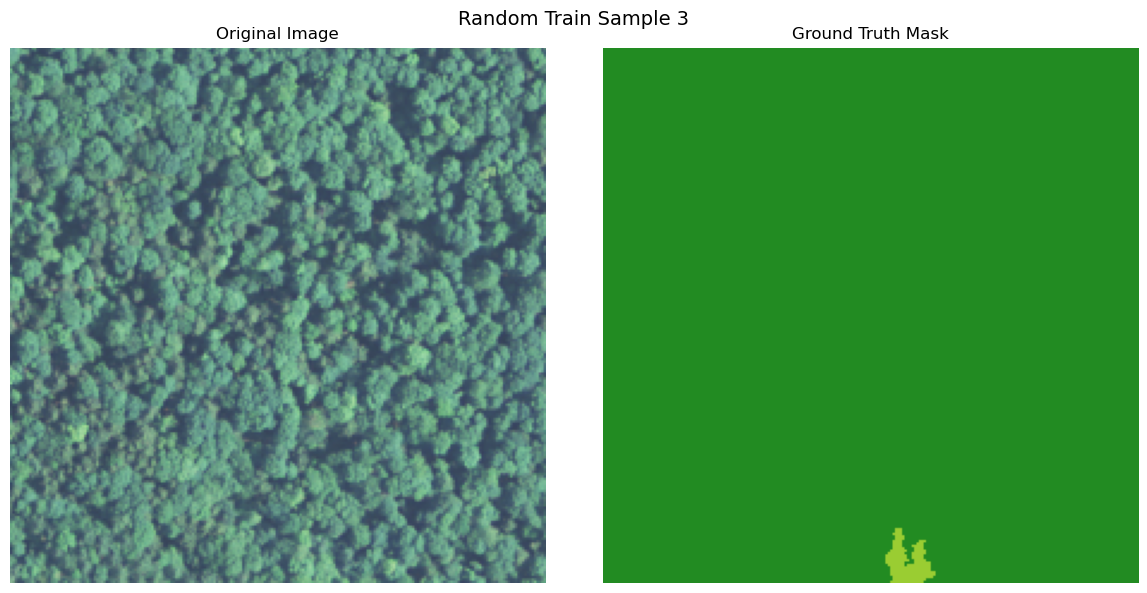

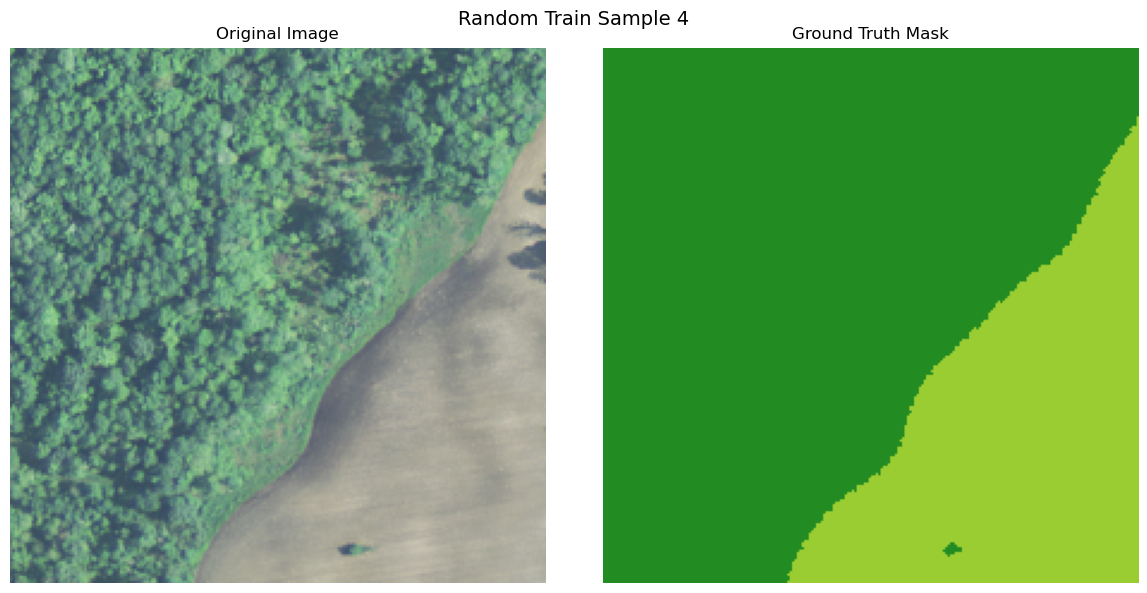

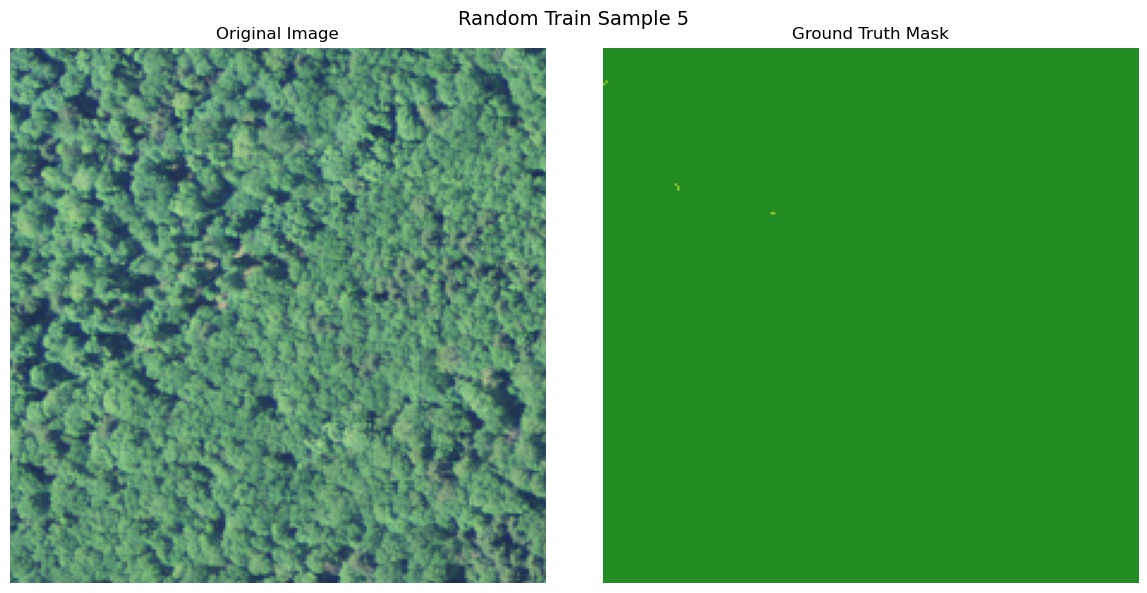

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_image_mask_pair(image, true_mask, pred_mask=None, title="Image and Mask Comparison"):
    color_map = {
        0: (0, 0, 255),     # Deep Blue for water
        1: (34, 139, 34),   # Forest Green for tree canopy / forest
        2: (154, 205, 50),  # Yellow Green for low vegetation / field
        3: (210, 180, 140), # Tan for barren land
        4: (169, 169, 169), # Dark Gray for impervious (other)
        5: (105, 105, 105), # Dim Gray for impervious (road)
        6: (255, 255, 255), # White for no data
    }

    def create_colored_mask(mask):
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                colored_mask[i, j] = color_map[mask[i, j]]
        return colored_mask

    true_colored_mask = create_colored_mask(true_mask)
    
    n_cols = 3 if pred_mask is not None else 2
    
    fig_width = 6 * n_cols
    fig_height = 6
    fig, axes = plt.subplots(1, n_cols, figsize=(fig_width, fig_height))
    
    if n_cols == 2:
        axes = [axes[0], axes[1]]
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(true_colored_mask)
    axes[1].set_title("Ground Truth Mask", fontsize=12)
    axes[1].axis('off')
    
    if pred_mask is not None:
        pred_colored_mask = create_colored_mask(pred_mask)
        axes[2].imshow(pred_colored_mask)
        axes[2].set_title("Predicted Mask", fontsize=12)
        axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


with h5py.File(output_file, "r") as f:
    
    dataset = f["data"]
    random_indices = np.random.choice(len(dataset), 5, replace=False)
    
    for i, idx in enumerate(random_indices):
        image = dataset[idx]['pixels'].astype("int64").transpose(1, 2, 0)
        true_mask = dataset[idx]['label']

        if image.shape[2] > 3:
            image = image[:, :, :3]

        visualize_image_mask_pair(image=image, true_mask=true_mask, title=f"Random Train Sample {i+1}")

## Uploading Data to Bluesight

In [7]:
import requests
from requests_toolbelt.multipart.encoder import MultipartEncoder
from pprint import pprint

def upload_file(file_path):
    file_name = os.path.basename(file_path)
    encoder = MultipartEncoder(
        fields={'file': (file_name, open(file_path, 'rb'), 'application/octet-stream')}
    )
    
    response = requests.post(
        f"{API_URL}/files",
        data=encoder,
        headers={'Content-Type': encoder.content_type}
    )
    
    if response.status_code == 200:
        print("File uploaded successfully!")
        return response.json()
    else:
        print(f"Failed to upload file. Status code: {response.status_code}")
        print(f"Response: {response.text}")
        return None

In [8]:
%%time
file_object = upload_file(output_file)
pprint(file_object, sort_dicts=False)

File uploaded successfully!
{'id': 'file-c6pyf79g',
 'bytes': 262418408,
 'created_at': 1722456495,
 'filename': 'land_segmentation_train_data.h5'}
CPU times: user 1.5 s, sys: 298 ms, total: 1.8 s
Wall time: 2min 5s


## Starting Training

Now we need to load data to the format which is accepted by our API. Essentially, it is raw pixels data from all bands with some metadata.

In [46]:
def create_training_job(task, training_file, validation_file=None):

    payload = {"task": task, "training_file": training_file, "validation_file": validation_file}
    
    response = requests.post(
        f"{API_URL}/training/jobs",
        json=payload,
        headers={'Content-Type': "application/json"}
    )
    
    if response.status_code == 200:
        print("Training job submitted successfully!")
        return response.json()
    else:
        print(f"Failed to sumbit training job. Status code: {response.status_code}")
        print(f"Response: {response.text}")
        return None

In [47]:
training_job = create_training_job("segmentation", file_object["id"])
pprint(training_job, sort_dicts=False)

Training job submitted successfully!
{'task': 'segmentation',
 'training_file': 'file-c6pyf79g',
 'validation_file': None,
 'hyperparameters': None,
 'id': 'trainingjob-cjhzikag',
 'created_at': 1722457908,
 'status': 'initializing',
 'error': None,
 'trained_model': None,
 'finished_at': None}


In [48]:
def retrieve_training_job(job):
    response = requests.get(
        f"{API_URL}/training/jobs/{job}"
    )
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to retrieve training job. Status code: {response.status_code}")
        print(f"Response: {response.text}")
        return None

In [49]:
%%time
import time

status = None
while status not in ("succeeded", "failed", "cancelled"):
    training_job = retrieve_training_job(training_job["id"])
    status = training_job["status"]
    print(status)
    time.sleep(20)
pprint(training_job)

initializing
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
succeeded
{'created_at': 1722457908,
 'error': None,
 'finished_at': 1722459229,
 'hyperparameters': None,
 'id': 'trainingjob-cjhzikag',
 'status': 'succeeded',
 'task': 'segmentation',
 'trained_model': 'model:segmentation-juo7qapo',
 'training_file': 'file-c6pyf79g',
 'validation_file': None}
CPU times: user 562 ms, sys: 52.9 ms, total: 615 ms
Wall time: 22min 29s


## Run inference

For inference we need only images.

You can check detailed endpoint specification [in the docs](https://docs.bluesight.ai/api-reference/inference/infer-segmentation-model).

In [50]:
X_test = [{
    "gsd": GSD,
    "bands": BANDS,
    "pixels": np.load(OUTPUT_DIR / "val/chips" / chip_name).tolist(),
    "platform": COLLECTION
} for chip_name in tqdm(val_chip_names[:N_TEST_SAMPLES])]
y_test = np.array([np.vectorize(label_mapping.get)(np.load(OUTPUT_DIR / "val/labels" / chip_name).squeeze()).tolist() for chip_name in tqdm(val_label_names[:N_TEST_SAMPLES])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 140.44it/s]


In [51]:
def run_trained_model_inference(model, images):
    payload = {"model": model, "images": images}
    
    response = requests.post(
        f"{API_URL}/inference",
        json=payload,
        headers={'Content-Type': "application/json"}
    )
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to run inference. Status code: {response.status_code}")
        print(f"Response: {response.text}")
        return None

In [54]:
%%time
y_pred = run_trained_model_inference(training_job["trained_model"], X_test)
y_pred = np.array(y_pred["labels"])

CPU times: user 3.79 s, sys: 183 ms, total: 3.97 s
Wall time: 1min 24s


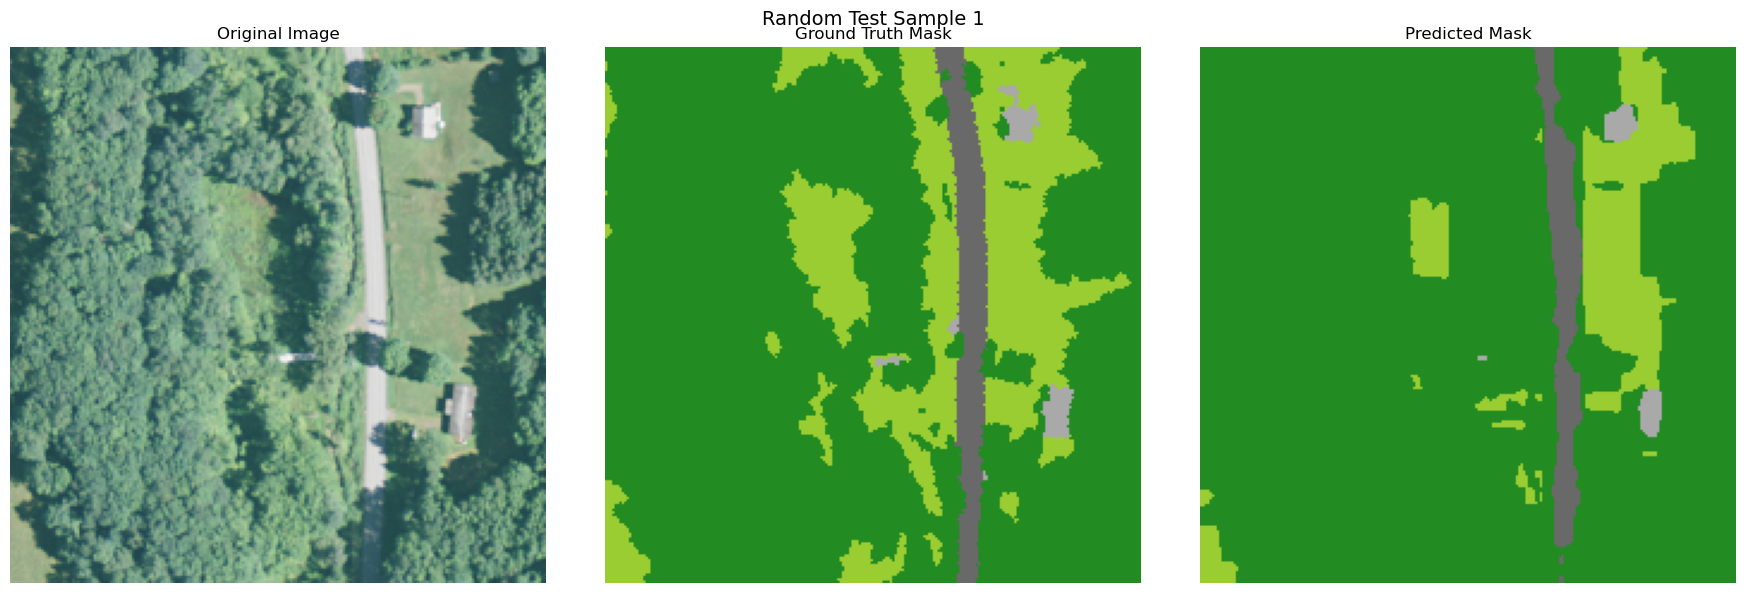

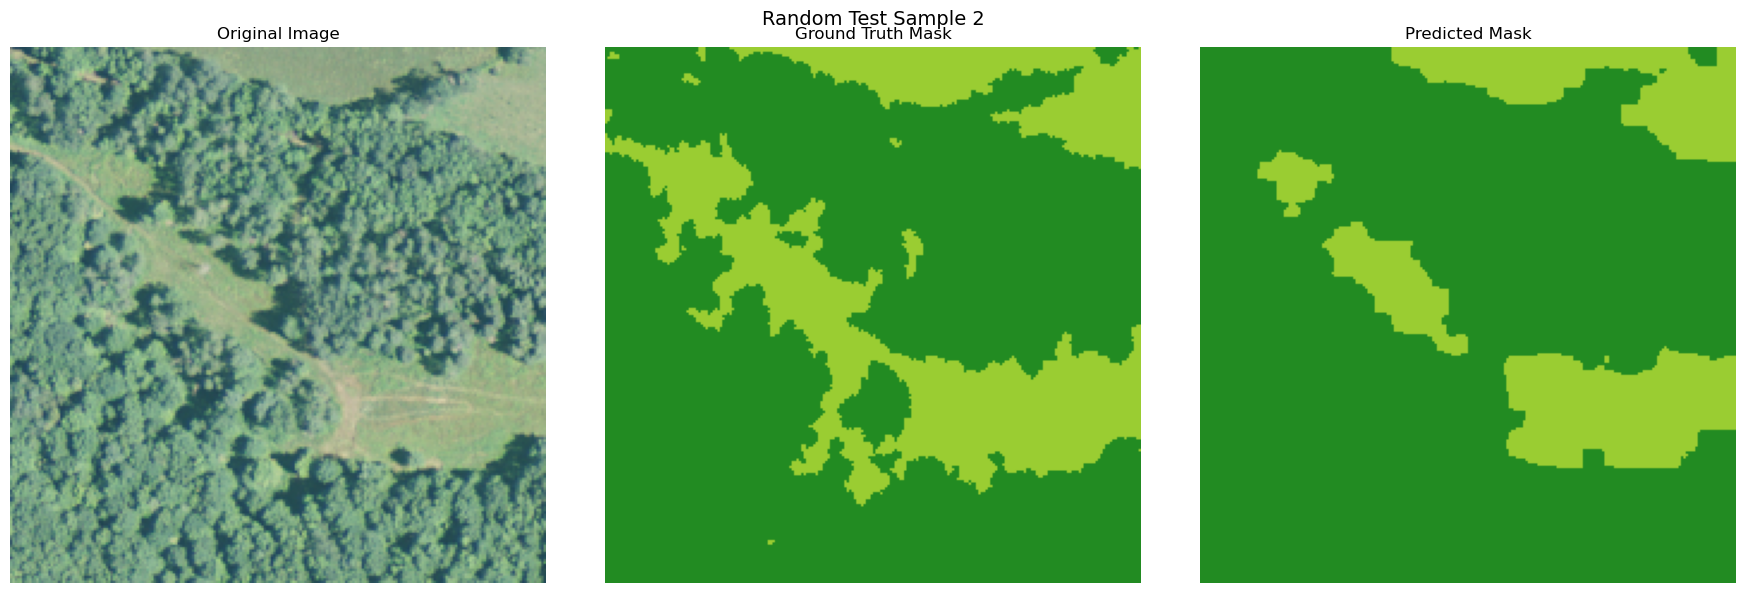

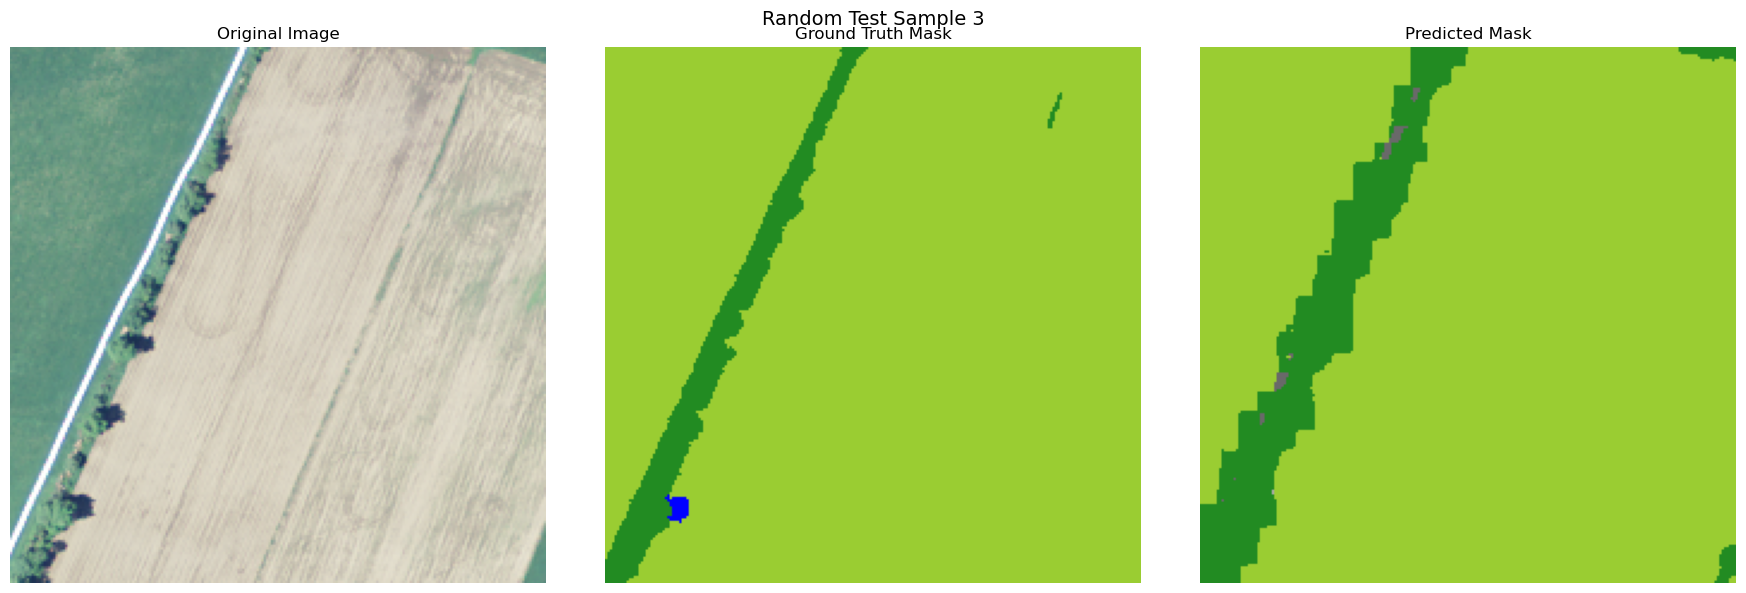

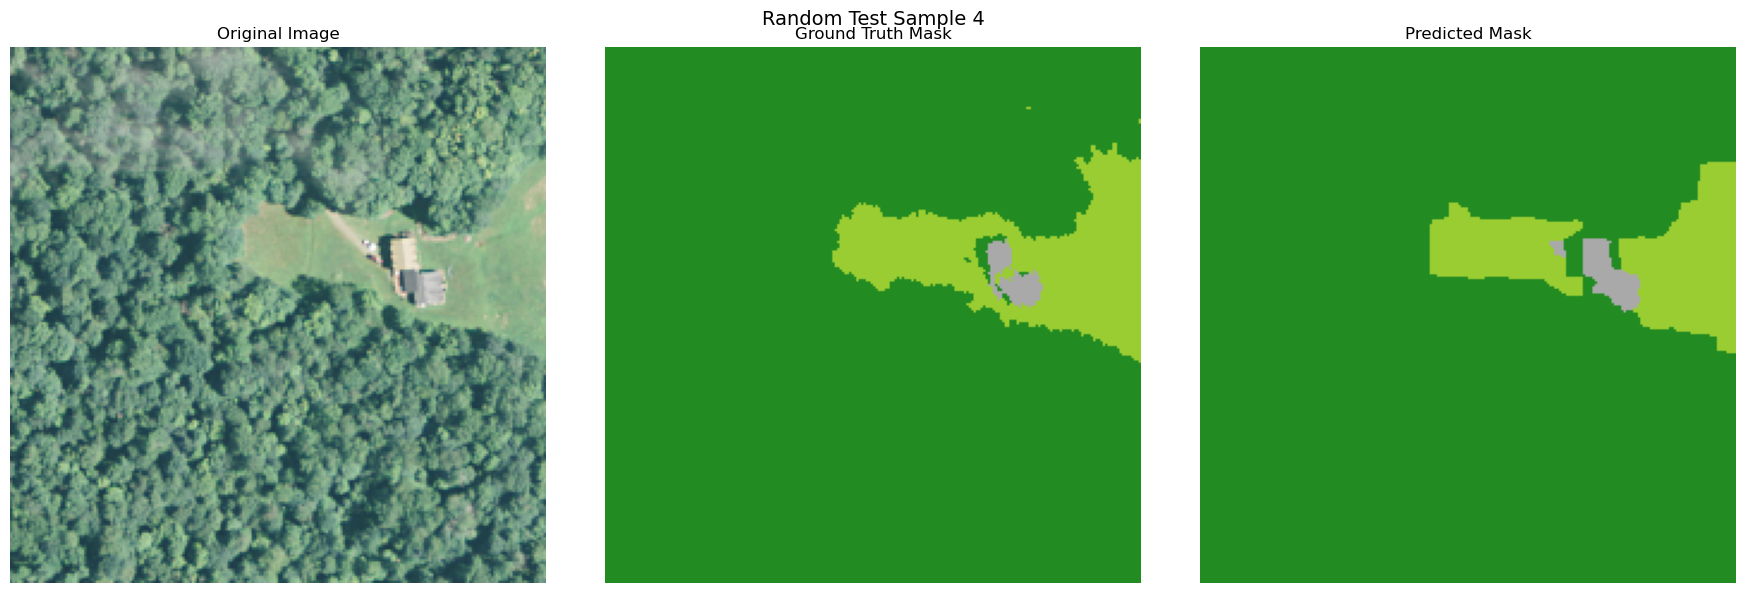

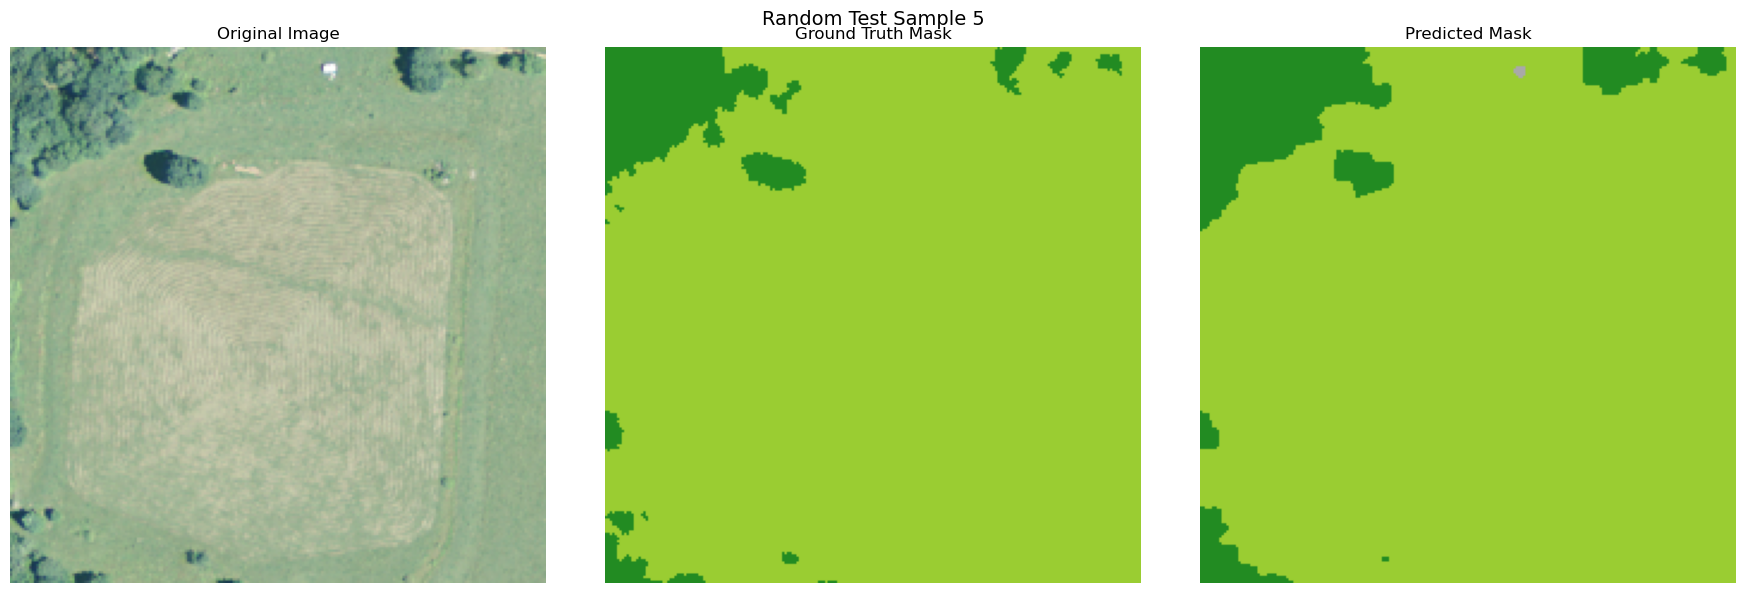

In [55]:
random_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(random_indices):
    image = np.array(X_test[idx]['pixels']).transpose(1, 2, 0)
    true_mask = y_test[idx]
    pred_mask = y_pred[idx]
    
    if image.shape[2] > 3:
        image = image[:, :, :3]
    
    visualize_image_mask_pair(image=image, true_mask=true_mask, pred_mask=pred_mask, title=f"Random Test Sample {i+1}")

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def calculate_segmentation_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    pixel_accuracy = accuracy_score(y_true_flat, y_pred_flat)
    
    mean_iou = jaccard_score(y_true_flat, y_pred_flat, average='macro')
    
    precision = precision_score(y_true_flat, y_pred_flat, average='macro')
    recall = recall_score(y_true_flat, y_pred_flat, average='macro')
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
    
    return {
        'confusion_matrix': cm,
        'pixel_accuracy': pixel_accuracy,
        'mean_iou': mean_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

metrics = calculate_segmentation_metrics(y_test, y_pred)

for metric, value in metrics.items():
    print(f"{metric}:")
    print(value)
    print()

/home/furiousteabag/.local/share/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion_matrix:
[[ 141414   34499    1080       0   12725     802]
 [     28 2547949   34625       0     706    2085]
 [    223  353288 1724957       0   13209    3458]
 [      0     839    3413       0   27148       0]
 [     14    7318    1664       0   37640    4203]
 [      0   12461    4086       0    5970   41796]]

pixel_accuracy:
0.8955986926020408

mean_iou:
0.5495000999801362

precision:
0.6699292665323794

recall:
0.6568909938179078

f1_score:
0.6479898726350027

